<a href="https://colab.research.google.com/github/pablocontini/Taller-de-Procesamiento-de-Datos/blob/main/TPS04_An%C3%A1lisis_de_Discriminante_y_Vecinos_m%C3%A1s_cercanos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

**Análisis de Discriminante y Vecinos más cercanos**

Iris es un género de plantas rozomatosas de la familia Iridaceae. Dentro de las plantas de Iris existen muchas especies distintas, entre ellas *setosa*, *versicolor* y *virgínica*. Se desea desarrollar un clasificador de dichas plantas a partir del tamaño de su sépalo.

(a) *Exploración de datos:*
- Cargar la base de datos utilizando $\texttt{datasets.load_iris}$ (sklearn). Utilizar solamente las dimensiones del sépalo. Graficar las muestras en un `scatter`, representando las diferentes especies de Iris con colores distintos.
- Utilice el comando `train_test_split` (sklearn) para definir los conjuntos de entrenamiento y testeo con las proporciones 70\% y 30\%.

(b) *Clasificación LDA:*
- Implementar un algoritmo de LDA a partir de las dimensiones del sépalo para clasificar las plantas de Iris. El código debe estar estructurado de la siguiente manera:
```
class LDA
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self,...

    # Etapa de entrenamiento
    def fit(self, X, y):

    # Etapa de testeo soft
    def predict_proba(self, X):

    # Etapa de testeo hard
    def predict(self, X):
```
- Superponer al `scatter` las medias y las covarianzas de cada gaussiana (una curva de nivel) del modelo de LDA.
- Superponer al `scatter` las fronteras de decisión. <img src="https://i.ibb.co/tTfkc8DH/image.png" width="25" />: Funciones como `meshgrid` (numpy) y `contour` (matplotlib) pueden ser útiles para graficar las fronteras.
- Reportar el accuracy de testeo.

(c) *Síntesis:* Utilizando el modelo LDA, generar 30 muestras sintéticas y graficarlas junto a las fronteras. Representar las diferentes especies de Iris con colores distintos.

<img src="https://i.ibb.co/tTfkc8DH/image.png" width="25" />: Tenga en cuenta que, además de las medias y varianzas, deberá utilizar las probabilidades $c_k$ aprendidas durante el entrenamiento. Funciones como `random.choice` y `random.multivariate_normal` (numpy) pueden ser útiles.


(d) *Discriminante cuadrático:* Repetir los incisos (b) y (c) utiliando el algoritmo QDA. <img src="https://i.ibb.co/tTfkc8DH/image.png" width="25" />: Dada la similitud entre ambos algoritmos, se recomienda modificar el código anterior utilizando un hiperparámetro que indique si estamos en un análisis lineal o cuadrático.

(e) *K vecinos más cercanos:* Repetir el inciso (b) utilizando un algoritmo KNN con $K=6$ (excepto por las curvas de nivel asociadas a las medias y covarianzas que aquí no corresponden).



# (a) Exploración de datos

## Carga del dataset

El dataset Iris es un dataset multivariante introducidor por Ronald Fisher en su artículo de 1936, *The use of multiple measurements in taxonomic problems* como un ejemplo de análisis de discriminante lineal.

Sus características principales son:
1. 150 muestras (50 por cada especie)
2. 3 etiquetas (clases) correspondientes a cada especie:
  - `0`: setosa
  - `1`: versicolor
  - `2`: virginica
3. 4 atributos numéricos (features):
  - `sepal length`: longitud del sépalo (en cm)
  - `sepal width`: ancho del sépalo (en cm)
  - `petal length`: longitud del pétalo (en cm)
  - `petal width`: ancho del pétalo (en cm)

Para la carga del dataset se utiliza la función `datasets.load_iris` de scikit-learn y se toman solo las dimensiones del sépalo (las dos primeras columnas).


In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, :2]   # Solo sepal length, sepal width
y = iris.target        # Etiquetas: 0->setosa, 1->versicolor, 2->virginica

print("Nombres de las columnas (features): ",iris.feature_names)
print("Nobress de las clases: ", iris.target_names)
print("Dimensiones de X:", X.shape)

Nombres de las columnas (features):  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Nobress de las clases:  ['setosa' 'versicolor' 'virginica']
Dimensiones de X: (150, 2)


## Gráfico de dispersión (scatter) de las muestras

Se realiza un `scatterplot` de las dos características que se van a utilizar: el largo y el ancho del sépalo, asignando un marcador y un color diferente para cada especie.

Se observan dos agrupamientos diferentes. Uno que contiene la clase *Iris setosa* y otro que contiene tanto *Iris virginica* como *Iris versicolor*.

La especie *setosa* se concentra en la parte izquierda del gráfico, con valores de longitud de sépalo más pequeños y con valores de ancho de sépalo, en general, más grandes que las otras especies. Por lo tanto en este plano (`sepal length`, `sepal width`) la clase *setosa* se separa bien del resto.

Se observa también un solapamiento entre la clase *versicolor* y la clase *virginica*, ambas se encuentran en la parte central y derecha del gráfico. Es decir, sólo con estas dos variables (largo y ancho del sépalo), la separación no es clara como entre *setosa* y las demás.

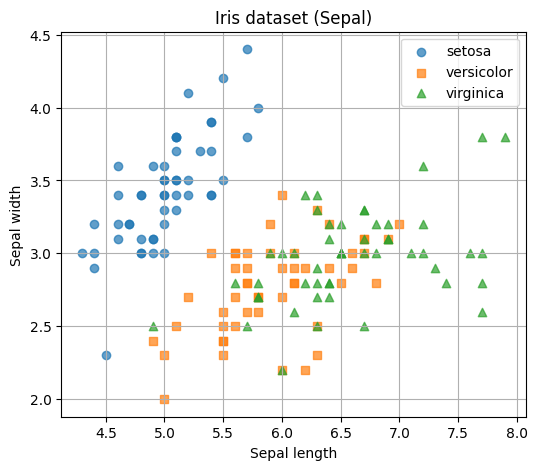

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_sepal(X, y, title="Scatter de sépalos"):
    # y (target) = 0,1,2 => setosa, versicolor, virginica
    markers = ['o', 's', '^']
    for clase in np.unique(y):
        plt.scatter(
            X[y == clase, 0],
            X[y == clase, 1],
            label=iris.target_names[clase],
            alpha=0.7,
            marker=markers[clase]
        )
    plt.title(title)
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(6,5))
plot_scatter_sepal(X, y, "Iris dataset (Sepal)")
plt.show()


## Definición de los conjuntos

Se divide el dataset en entrenamiento (70\%) y test(30\%). Se mezclan aleatoriamente las muestras y se conservan las proporciones para que cada subconjunto tenga una representación balanceada de cada clase. A tal fin se utiliza la función `train_test_split` de scikit-learn con los siguientes parámetros:
- `test_size=0.3`: Este argumento especifica que 30 % de los datos se utilizará para pruebas y el 70 % restante para entrenamiento.
- `stratify = y` garantiza que la proporción de muestras que representan cada especie se mantenga tanto en el conjunto de entrenamiento como en el de prueba. Esto es importante para evitar desequilibrios que podrían sesgar el rendimiento del modelo.
- `random_state = 42`: Utilizar una semilla fija para el generador de números aleatorios garantiza que se obtenga la misma división cada vez que se ejecuta el código, lo cual facilita la reproducibilidad.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)


Tamaño de X_train: (105, 2)
Tamaño de X_test: (45, 2)


# (b) Clasificación LDA

## Implementación del algoritmo de LDA

El Análisis de Discriminante Lineal (LDA, por sus siglas en inglés) es un método de clasificación supervisado cuyo objetivo principal es encontrar una combinación lineal de las características que mejor separe dos o más clases de objetos o eventos.

Se basa en la idea de encontrar una o más funciones discriminantes que, cuando se evalúan en un vector de entrada $\mathbf{x}$, determinan a qué clase se debe asignar esa entrada. En LDA, esas funciones son lineales, lo que significa que toman la forma $g_k(\mathbf{x}) = \mathbf{w}k^T \mathbf{x} + w{k_0}$, donde $\mathbf{w}k$  es un vector de pesos específicos paa la clase $C_k$ y $w{k_0}$ es un término de sesgo o umbral. La superficie de decisión entre dos clases estará definida por los puntos donde sus funciones discriminantes sean iguales, es decir, $g_i(\mathbf{x}) = g_j(\mathbf{x})$, lo que resulta en una hiperplano.

En LDA se asume que las densidades de probabilidad condicionales de clase $p(\mathbf{x}|C_k)$ siguen una distribución gaussiana multivariante con una matriz de covarianza común $\mathbf{\Sigma}$ para todas las clases, pero con vectores de medias diferentes $\mathbf{\mu}_k$ para cada clase. La función discriminante lineal surge al tomar el logaritmo de la razón de las probabilidades posteriores $P(C_k|\mathbf{x})$ utilizando el teorema de Bayes y las probabilidades a priori.

Su implementación consta del del constructor de la clase `__init__`;  y los métodos `fit`, `predict_proba` y `predict`.

- En el constructor se almacenarán los atributos:
  - `means_`: medas de cada clase
  - `cov_`: matriz de covarianza común a todas las clases
  - `priors_`: probabilidades a priori de cada clase
- En el método `fit` se calculan las fórmulas de estimación de parámetros necesarios para luego poder predecir con LDA:
  - **La media de cada clase** ($\mu_k$):

    $$\mu_k=\frac{1}{n_k}\sum_{i:y_i=k}X_i$$
    mediante `self.means_[cl, :] = np.mean(X_class, axis=0)`
    donde `cl` es la etiqueta de la clase y `X_class` contiene todas las muestras de la clase y `axis=0` indica promediado por filas.

  - **La probabilidad a priori de cada clase** ($\pi_k$).

    $$\pi_k=\frac{n_k}{N}$$
    que se calcula como `self.priors_[cl] = X_class.shape[0] / float(n_samples)
    `donde `X_class.shape[0]` es $n_k$ y `n_samples` es el número de muestras $N$.

  - La matriz de covarianza común sumando las contribuciones de cada clase y dividiendo por $N-n_{\text{clases}}$:
  $$\Sigma=\frac{1}{N-C}\sum_{k=0}^{C_1}\sum_{i:y_i=k}(x_i-\mu_k)(x_i-\mu_k)^T$$

    Para esto primero se construye el array cuyas filas son $x_i-\mu_k$ mediante `diff = X_class - self.means_[cl, :]`, se lo multiplica por su transpuesto y se lo almacena gradualmente en cada ciclo `cov_acum += diff.T @ diff`. Finalmente una vez que se sumó para todas las clases, se lo divide por &N-C& mediante: `self.cov_ = cov_acum / (n_samples - self.n_classes_)`
- El método `predict_proba` calcula la probabilidad prosterior de cada clase dadas las muestras $X$.

  Bajo este modelo, la probabilidad posterior se expresa como:
  $$p(\text{Clase}=k\mid x)=\frac{p(x\mid \text{Clase}=k)p(\text{Clase}=k)}{\sum_{j=0}^{C-1}\left[p(x\mid \text{Clase}=j)p(\text{Clase}=j)\right]}$$
  donde
  $$p(x\mid \text{Clase}=k)=\frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}}e^{-\frac{1}{2}(x-\mu_k)^T\Sigma^{-1}(x-\mu_k)}$$
  - La inversa y el determinante de $\Sigma$ se calculan mediante `cov_inv = np.linalg.inv(self.cov_)` y `cov_det = np.linalg.det(self.cov_)`
  - Mediante un bucle sobre las clases se calcula $p(x\mid k)p(k)$ haciendo
    ```python
      for clase in range(self.n_classes_):
        mu = self.means_[clase]
        prior = self.priors_[clase]
        diff = X - mu
        expo_term = np.sum(diff @ cov_inv * diff, axis=1)  
        pdf = np.exp(-0.5 * expo_term) / np.sqrt((2 * np.pi)**X.shape[1] * cov_det)
        post[:, clase] = prior * pdf
    ```
    y luego se las normaliza mediante `post /= post.sum(axis=1, keepdims=True)`. Dividir elemento a elemento hace que la suma por clase sea 1 en cada fila.

    El resultado es una matriz donde cada fila i representa
    $$[p(\text{Clase}=0\mid x_i),p(\text{Clase}=1\mid x_i),\dots,p(\text{Clase}=C-1\mid x_i)]$$

    De esta manera ofrece la salida soft de LDA.
- El método `predict` calcula la predicción dura tomando el argmax de la probabilidad posterior para asignar la clase con mayor probabilidad mediante `np.argmax(post, axis=1)`.

In [ ]:
class LDA:
  def __init__(self):
    """
    - means_ (medias) de cada clase
    - cov_ matriz de covarianza (compartida)
    - priors_ probabilidades a priori de cada clase
    - n_classes_ número de clases
    """
    self.means_ = None
    self.cov_ = None
    self.priors_ = None
    self.n_classes_ = None

  def fit(self, X, y):
    """
    Ajusta la media, la covarianza (compartida) y los priors para cada clase.

    Parámetros:
    X: shape [n_samples, n_features]
    y: shape [n_samples]
    """
    # Número de clases
    self.n_classes_ = len(np.unique(y))
    # total de muestras N y la dimensión d
    n_samples, n_features = X.shape

    # Inicializado de arrays para medias y probabilidades a priori
    self.means_ = np.zeros((self.n_classes_, n_features)) # mu_k
    self.priors_ = np.zeros(self.n_classes_) # pi_k

    for cl in range(self.n_classes_):
      # Filtra las filas que pertenecen a la clase
      X_class = X[y == cl]
      # Media: mu_k = (1/n_k) * sum_{i : y_i = k}( X_i )
      self.means_[cl, :] = np.mean(X_class, axis=0)
      # Probabilidad a priori de la clase k:  pi_k = n_k / N
      self.priors_[cl] = X_class.shape[0] / float(n_samples)

    # Matriz de covarianza compartida
    cov_acum = np.zeros((n_features, n_features))

    for cl in range(self.n_classes_):
      # Filtra las filas que pertenecen a la clase
      X_class = X[y == cl]
      # (x_i - mu_k) para cada muestra i de la clase k
      diff = X_class - self.means_[cl, :]
      # cov_acum += sum_{i : y_i = k}( diff_i^T * diff_i )
      cov_acum += diff.T @ diff

    # Sigma = 1 / (N - C) * sum_{k=0}^{C-1} sum_{i : y_i = k} (X_i - mu_k)(X_i - mu_k)^T
    self.cov_ = cov_acum / (n_samples - self.n_classes_)

  def predict_proba(self, X):
      """
      Retorna la probabilidad posterior de cada clase para las muestras de X.
      Parámetros:
      X [n_samples, n_features]
      """
      n_samples = X.shape[0]
      # Inversa y determinante
      cov_inv = np.linalg.inv(self.cov_)
      cov_det = np.linalg.det(self.cov_)

      # Prealocamos posterior
      post = np.zeros((n_samples, self.n_classes_))

      for clase in range(self.n_classes_):
        # Media y prior
        mu = self.means_[clase]
        prior = self.priors_[clase]


        # (X - mu)
        diff = X - mu
        # (x - mu)^T Sigma^{-1} (x - mu)
        expo_term = np.sum(diff @ cov_inv * diff, axis=1)
        # pdf gaussiana multivariable
        # p(x|k) = 1 / [ (2pi)^(d/2) * |Sigma|^(1/2) ] * exp(-0.5 * expo_term)
        pdf = np.exp(-0.5 * expo_term) / np.sqrt((2 * np.pi)**X.shape[1] * cov_det)
        post[:, clase] = prior * pdf

      # Normalización a 1
      post /= post.sum(axis=1, keepdims=True)
      return post

  def predict(self, X):
      """
      Predicción hard: la clase con mayor posterior.
      """
      post = self.predict_proba(X)
      return np.argmax(post, axis=1)


## Medias, covarianza de cada gaussiana y fronteras de decisión

A continuación, se grafica superpuestos:
1. **Medias**: indicadas como puntos.
2. **Covarianzas**: se muestra como una curva de nivel en trono a cada media utilizando la misma.
3. **Fronteras de decisión**: definiendo una grilla en el espacio y calculando la clase predicha para cada punto, la frontera se encuentra donde cambie la clase.

A partir del gráfico resultante para el set de entrenamiento se puede observar lo siguiente:
- Se obtienen regiones bien definidas para cada clase.
- La frontera entre *versicolor* y *virginica* pasa aproximadamente por la zona central, donde se produce cierto solapamiento de muestras.
- Se observa que algunas muestras quedan del lado opuesto y podrían ser clasificadas erróneamente.
- Las elipses de covarianza muestran que la dispersión de *setosa* es menor en comparación con el resto, ya que menos muestras quedan fuera de la elipse.

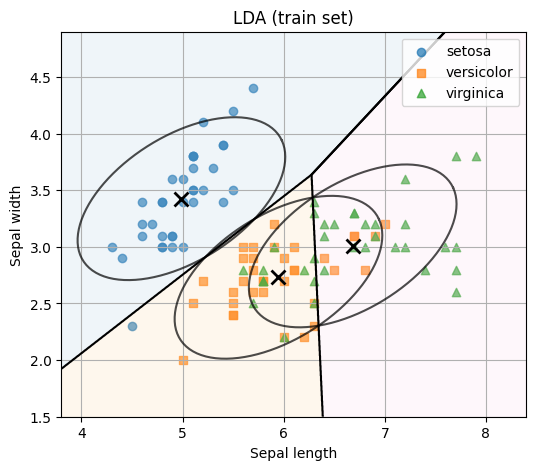

In [ ]:
def plot_lda_boundaries(lda_model, X, y, title="LDA Boundaries"):
    # 1) scatter de datos originales
    plot_scatter_sepal(X, y, title)

    # 2) Medias
    for cl in range(lda_model.n_classes_):
        mu = lda_model.means_[cl]
        plt.plot(mu[0], mu[1], 'kx', markersize=10, markeredgewidth=2)

    # 3) Elipses de covarianza (centrada en c/ media)
    cov = lda_model.cov_
    from numpy.linalg import eig
    vals, vecs = eig(cov)

    # Para distintos niveles
    for cl in range(lda_model.n_classes_):
        mu = lda_model.means_[cl]
        # Graficar elipse en 1 desviación, 2 desviaciones, etc.
        for n_std in [2]:
            # Radio de la elipse ~ sqrt(val) * n_std
            # vectores principales => vecs
            # vals => valores propios
            theta = np.linspace(0, 2*np.pi, 100)
            # definimos la elipse en el espacio de ejes principales
            ellipse = np.array([
                n_std * np.sqrt(vals[0]) * np.cos(theta),
                n_std * np.sqrt(vals[1]) * np.sin(theta)
            ])
            # rotamos al espacio original
            ellipse = vecs @ ellipse
            # traslación a la media
            ellipse[0, :] += mu[0]
            ellipse[1, :] += mu[1]
            plt.plot(ellipse[0, :], ellipse[1, :], 'k', alpha=0.7)

    # 4) Frontera de decisión
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 2000),
        np.linspace(y_min, y_max, 2000)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = lda_model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    plt.contourf(
        xx, yy, Z,
        alpha=0.2,
        levels=[-0.5, 0.5, 1.5, 2.5],
        cmap=plt.cm.Pastel1
    )

    plt.contour(xx, yy, Z, levels=[0.5,1.5], colors=['black','black'])
    plt.show()


# Entrenamiento del set de entrenamiento
lda_clf = LDA()
lda_clf.fit(X_train, y_train)


plt.figure(figsize=(6,5))
plot_lda_boundaries(lda_clf, X_train, y_train, "LDA (train set)")

## Accuracy de testeo

Se obtiene un 75.56\% de exactitud de testeo para el clasificador LDA utilizando las dos columnas del sépalo (longitud y ancho). Esto indica que las diferencias entre *versicolor* y *virginica* no se captura totalmente con las variables del sépalo. Es posible que mejore añadiendo más atributos (dimensiones del pétalo) o con otros métodos.

In [ ]:
# Predecimos sobre el set de test
y_pred_lda = lda_clf.predict(X_test)
accuracy_lda = np.mean(y_pred_lda == y_test)
print(f"Accuracy (Test) con LDA: {accuracy_lda*100:.4f}%")

Accuracy (Test) con LDA: 75.5556%


# (c) Síntesis

En LDA (y también en QDA), lo datos de cada clase se modelan mediante distribuciones gaussianas con parámetros estimados en la fase de entrenamiento (media, covarianza y probabilidades a priori de cada clase).

Dado que se asume un modelo definido para cada clase, se conoce la gaussiana $\mathcal{N}(\mu_k,\Sigma)$, junto con la probabilidad a priori $\pi_k$. Por lo tanto se puede:
1. Elegir una clase al azar (según la probablidad $\pi_k$)
2. Generar una muestra multivariada a partir de la gaussiana asociada a la clase (por ejemplo mediante `np.random.multivariate_normal`).

Esta muestra sintetizada se comporta como un dato que el modelo esperaría ver si el proceso generador fuera exactamente el que se asumió. En otras palabras, son modelos generativos.

A continuación, se generan 30 muestras y se grafica su posición respecto a las fronteras aprendidas. Como en el caso anterior, se observa que algunas muestras quedan del lado opuesto y fueron clasificadas erróneamente.

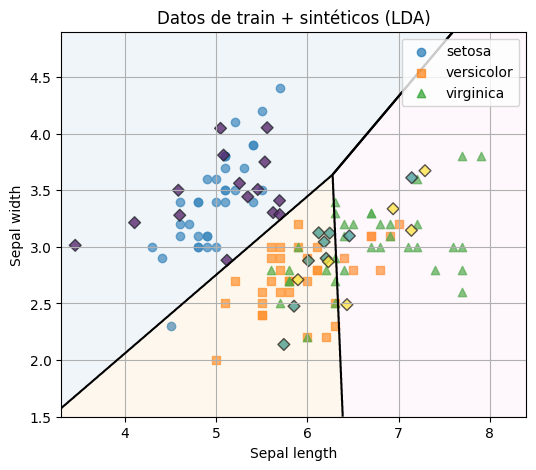

In [ ]:
np.random.seed(42)
n_sint = 30

synthetic_X = []
synthetic_y = []

for i in range(n_sint):
    # Elección de la clase segun los priors
    clase = np.random.choice(
        np.arange(lda_clf.n_classes_),
        p=lda_clf.priors_
    )
    # generación de la muestra gaussiana
    x_sint = np.random.multivariate_normal(
        mean=lda_clf.means_[clase],
        cov=lda_clf.cov_
    )
    synthetic_X.append(x_sint)
    synthetic_y.append(clase)

synthetic_X = np.array(synthetic_X)
synthetic_y = np.array(synthetic_y)

# Gráfico
plt.figure(figsize=(6,5))
plot_scatter_sepal(X_train, y_train, "Datos de train + sintéticos (LDA)")
# Muestra sintética
plt.scatter(synthetic_X[:,0], synthetic_X[:,1], c=synthetic_y, edgecolors='k', marker='D', alpha=0.8)
# Fronteras
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(
    np.linspace(x_min-0.5, x_max, 2000),
    np.linspace(y_min, y_max, 2000)
)
Z = lda_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0.5,1.5], colors=['black','black'])
plt.contourf(
    xx, yy, Z,
    alpha=0.2,
    levels=[-0.5, 0.5, 1.5, 2.5],
    cmap=plt.cm.Pastel1
)
plt.show()


# (d) Discriminante cuadrático QDA

## Implementación

El Análisis Discriminante Cuadrático **QDA (Quadratic Discriminant Analysis)** es un método de clasificación generativo. En QDA, se asume que la densidad de probabilidad condicional de cada clase sigue una distribución gaussiana multivariante. Sin embargo, a diferencia del Análisis Discriminante Lineal (LDA), QDA permite que cada clase tenga su propia matriz de covarianza.

Debido a que cada clase tiene su propia matriz de covarianza ($\mathbf{\Sigma}_k$) y su propio vector de medias ($\mathbf{\mu}_k$), la función discriminante resultante para la clase $k$ toma una forma cuadrática en función de la entrada.

La superficie de decisión entre dos clases cualesquiera ($k$ y $\ell$) está definida por los puntos donde $\delta_k(\mathbf{x}) = \delta_\ell(\mathbf{x})$, lo que resulta en una ecuación cuadrática. Esto permite a QDA modelar límites de decisión más complejos (curvos) que LDA, que solo puede generar límites lineales (hiperplanos).

En resumen, QDA es una extensión de LDA que permite límites de decisión cuadráticos al modelar cada clase con una distribución gaussiana con su propia matriz de covarianza. Esto le da más flexibilidad de capturar relaciones más complejas entre las características y las clases, pero también implica la necesidad de estimar más parámetros, lo que puede ser un desafío con conjuntos de datos pequeños.

En su implementación basta con:
1. Calcular $\mu_k$ y $\Sigma_k$ por separado para cada $k$.
2. La densidad posterior para cada clase $k$ se computa con su corrrespondiente $\Sigma_k$.


In [ ]:
class QDA:
    def __init__(self):
        """
        - means_ shape [n_clases, n_features]
        - covs_ lista de matrices de covarianza, una por clase
        - priors_ prob a priori
        """
        self.means_ = None
        self.covs_ = None
        self.priors_ = None
        self.n_classes_ = None

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        n_samples, n_features = X.shape

        self.means_ = np.zeros((self.n_classes_, n_features))
        self.covs_ = []
        self.priors_ = np.zeros(self.n_classes_)

        for clase in range(self.n_classes_):
            X_clase = X[y == clase]
            self.means_[clase, :] = np.mean(X_clase, axis=0)
            self.priors_[clase] = X_clase.shape[0] / float(n_samples)
            # Covarianza de esa clase
            diff = X_clase - self.means_[clase]
            cov_k = (diff.T @ diff) / (X_clase.shape[0] - 1)
            self.covs_.append(cov_k)

    def predict_proba(self, X):
        n_samples = X.shape[0]
        post = np.zeros((n_samples, self.n_classes_))

        for clase in range(self.n_classes_):
            mu = self.means_[clase]
            cov = self.covs_[clase]
            prior = self.priors_[clase]

            cov_inv = np.linalg.inv(cov)
            cov_det = np.linalg.det(cov)

            diff = X - mu
            expo_term = np.sum(diff @ cov_inv * diff, axis=1)
            pdf = np.exp(-0.5 * expo_term) / np.sqrt((2*np.pi)**X.shape[1] * cov_det)
            post[:, clase] = prior * pdf

        post /= post.sum(axis=1, keepdims=True)
        return post

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


## Muestras, medias, covarianza de cada gaussiana y fronteras de decisión

A continuación, se grafica como para LDA, las muestras de entrenamiento, la media y varianza de cada gaussiana y las fronteras de decisión.

Al observar el gráfico se destacan los siguietnes puntos:
- A diferencia de LDA aquí las separaciones entre clases son curvas. Esto se debe a que QDA asume una covarianza distinta para cada clase, lo que permite modelar mejor su geometría en el espacio.
- Cada clase tiene una elipse con distinta forma y orientación. Esto refleja que las dispersiones de `setosa`, `versicolor` y `virginica` son estimadas de manera independiente.
- El modelo QDA ofrece una frontera de decisión más compleja y curvada, que captura mejor la variabilidad de cada clase. Si bien el solapamiento entre `versicolor` y `virginica` sigue existiendo, se maneja de forma más flexible que con LDA.

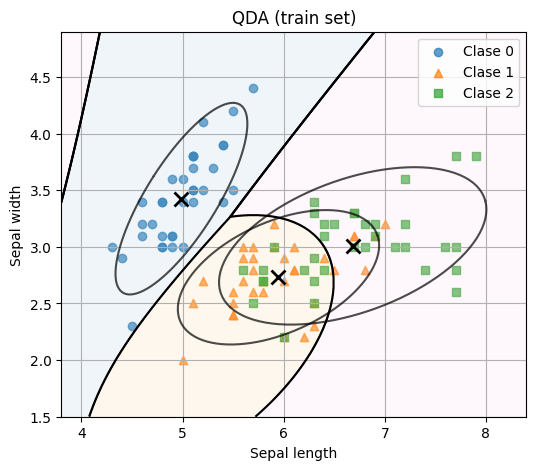

In [ ]:
def plot_qda_boundaries(qda_model, X, y, title="QDA Boundaries"):
    plot_scatter_sepal(X, y, title)

    # Medias y elipses
    from numpy.linalg import eig
    for clase in range(qda_model.n_classes_):
        mu = qda_model.means_[clase]
        plt.plot(mu[0], mu[1], 'kx', markersize=10, markeredgewidth=2)
        cov = qda_model.covs_[clase]
        vals, vecs = eig(cov)
        for n_std in [2]:
            theta = np.linspace(0, 2*np.pi, 100)
            ellipse = np.array([
                n_std * np.sqrt(vals[0]) * np.cos(theta),
                n_std * np.sqrt(vals[1]) * np.sin(theta)
            ])
            ellipse = vecs @ ellipse
            ellipse[0, :] += mu[0]
            ellipse[1, :] += mu[1]
            plt.plot(ellipse[0, :], ellipse[1, :], 'k', alpha=0.7)

    # Fronteras
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 2000),
        np.linspace(y_min, y_max, 2000)
    )
    Z = qda_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0.5,1.5], colors=['black','black'])
    plt.contourf(
      xx, yy, Z,
      alpha=0.2,
      levels=[-0.5, 0.5, 1.5, 2.5],
      cmap=plt.cm.Pastel1
    )
    plt.show()

qda_clf = QDA()
qda_clf.fit(X_train, y_train)


plt.figure(figsize=(6,5))
plot_qda_boundaries(qda_clf, X_train, y_train, "QDA (train set)")


## Accuracy de testeo

La **exactitud** obtenida con el método **QDA**, de **71.1\%**, resulta **inferior** a la de LDA. Un factor que podría explicar este desempeño es la **menor cantidad de muestras** disponibles para estimar la matriz de covarianza por clase, lo que puede derivar en **sobreajuste** al conjunto de entrenamiento. Además, aunque QDA sea **más flexible**, esa flexibilidad no necesariamente mejora la separabilidad cuando la información principal radica en las **dimensiones del pétalo**, aquí no utilizadas.

Por su parte, LDA, al **compartir una única matriz de covarianza**, es menos flexible pero puede ser **más robusto** cuando hay pocos datos. QDA, en cambio, ofrece ventajas si cada clase tiene **covarianzas muy diferentes**, siempre y cuando se disponga de **suficientes muestras** para estimar esas matrices sin incurrir en sobreajuste.

In [ ]:
y_pred_qda = qda_clf.predict(X_test)
accuracy_qda = np.mean(y_pred_qda == y_test)
print(f"Accuracy (Test) con QDA: {accuracy_qda*100:.2f}%")


Accuracy (Test) con QDA: 71.11%


## Síntesis

Al igual que para LDA, se generan muestras sintéticas usando las $\Sigma_k$ correspondientes:

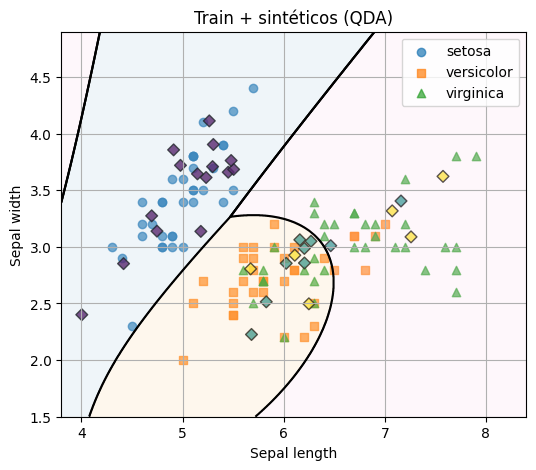

In [ ]:
np.random.seed(42)
n_sint_qda = 30

synthetic_X_qda = []
synthetic_y_qda = []
for i in range(n_sint_qda):
    clase = np.random.choice(np.arange(qda_clf.n_classes_), p=qda_clf.priors_)
    x_sint = np.random.multivariate_normal(
        mean=qda_clf.means_[clase],
        cov=qda_clf.covs_[clase]
    )
    synthetic_X_qda.append(x_sint)
    synthetic_y_qda.append(clase)

synthetic_X_qda = np.array(synthetic_X_qda)
synthetic_y_qda = np.array(synthetic_y_qda)

plt.figure(figsize=(6,5))
plot_scatter_sepal(X_train, y_train, "Train + sintéticos (QDA)")
plt.scatter(synthetic_X_qda[:,0], synthetic_X_qda[:,1], c=synthetic_y_qda, edgecolors='k', marker='D', alpha=0.8)

# Fronteras
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 2000),
    np.linspace(y_min, y_max, 2000)
)
Z = qda_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0.5,1.5], colors=['black','black'])
plt.contourf(
  xx, yy, Z,
  alpha=0.2,
  levels=[-0.5, 0.5, 1.5, 2.5],
  cmap=plt.cm.Pastel1
)
plt.show()


# (e) K vecinos más cercanos KNN

## Implementación

El método de los **K vecinos más cercanos (K-NN)** es un algoritmo de aprendizaje automático no paramétrico y supervisado que se utiliza tanto para clasificación como para regresión. Es un método simple donde la estructura del modelo está determinada por los datos.

Cuando se quiere clasificar un nuevo punto de datos, el algoritmo identifica los K puntos más cercanos a este nuevo punto dentro del conjunto de datos de entrenamiento. La cernanía se define típicamente usando una métrica de distancia como la distancia euclidiana.

Luego, se asigna al nuevo punto la clase que es más frecuente entre estos K vecinos más cercanos. Esto se conoce como votación por mayoría. En caso de empate se puede elegir aleatoriamente.

El valor de K controla el grado de suavizado de la frontera de decisión. Un valor pequeño de K puede llevar a un modelo muy ruidoso que se ajusta demasiado a los datos de entrenamiento (alta complejidad), mientras que un valor grande de K produce una frontera más suave (baja complejidad) que puede generalizar mejor pero podría pasar por alto patrones locales.

Es un método intuitivo y fácil de implementar, que puede llegar a un rendimiento razonable sin muchos ajustes y se utiliza a menudo como método de línea de base.

Por otro lado predicción puede ser lenta, especialmente con conjuntos de datos grandes, ya que requiere calcular la distancia al nuevo punto desde todos los puntos de entrenamiento. También es sensible a la escala de las características (features), por lo que puede ser importante preprocesar los datos para que todas las características tengan una escala similar. Por último, no funciona bien en espacios de alta dimensión ("la maldición de la dimensionalidad") ni con conjuntos de datos dispersos.

A continuación, se describe su implementación para este trabajo práctico:
- El constructor almacenará el número de vecinos (`n_neighbors`) y declara los conjuntos de datos de entrenamiento (`X_train` e `y_train`).
- El método `fit` simplementa almacenará el conjunto de datos de entrenamiento.
- El método `predict` predice la clase para cada muestra de la entrada 'X'.
  
  Para esto, primero calcula las distancias entre las muestras de 'X' y los datos de `X_train`. Luego obtiene los índices de los K vecinos más cercanos para cada muestra. Y finalmente realiza la predicción como la clase más frecuente dentro de los K vecinos para cada una de las muestras.
- El método `predict_proba` devuelve una estimación de la probabilidad (soft) a partir de las proporciones de vecinos de cada clase.

  Ésto se realiza de manera similar a `predict`. Esto es, calculando las distancias a los vecinos, obteniendo los K más cercanos, contando cuántos hay por cada clase, y finalmente, dividiendo por K, se obtienen las proporciones buscadas.

In [ ]:
class KNN:
  def __init__(self, n_neighbors=6):
    self.n_neighbors = n_neighbors
    self.X_train = None
    self.y_train = None

  def fit(self, X, y):
    """
    En KNN, "entrenar" básicamente consiste en almacenar el conjunto de datos.
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    """
    Predice la clase para cada muestra en X.
    Retorna un array de clases de la misma longitud que X.
    """
    y_pred = []
    for x in X:
      # Distancias a cada muestra del training
      dists = np.linalg.norm(self.X_train - x, axis=1)
      # Índices de los K vecinos más cercanos
      idx_k = np.argsort(dists)[:self.n_neighbors]
      # Clase que más se repite
      classes_k = self.y_train[idx_k]
      clase_pred = np.bincount(classes_k).argmax()
      y_pred.append(clase_pred)

    return np.array(y_pred)


  def predict_proba(self, X):
    n_muestras = X.shape[0]
    n_clases = len(np.unique(self.y_train))
    posterior = np.zeros((n_muestras, n_clases))

    for i, x in enumerate(X):
      dists = np.linalg.norm(self.X_train - x, axis=1)
      idx_k = np.argsort(dists)[:self.n_neighbors]
      classes_k = self.y_train[idx_k]
      # Vecinos por clase
      count = np.bincount(classes_k, minlength=n_clases)
      # Proporción
      posterior[i, :] = count / self.n_neighbors

    return posterior


In [ ]:
C
class KNN:
  def __init__(self, n_neighbors=6):
    self.n_neighbors = n_neighbors
    self.X_train = None
    self.y_train = None

  def fit(self, X, y):
    """
    En KNN, "entrenar" básicamente consiste en almacenar el conjunto de datos.
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    """
    Predice la clase para cada muestra en X.
    Retorna un array de clases de la misma longitud que X.
    """
    y_pred = []
    for x in X:
      # Distancias a cada muestra del training
      dists = np.linalg.norm(self.X_train - x, axis=1)
      # Índices de los K vecinos más cercanos
      idx_k = np.argsort(dists)[:self.n_neighbors]
      # Clase que más se repite
      classes_k = self.y_train[idx_k]
      clase_pred = np.bincount(classes_k).argmax()
      y_pred.append(clase_pred)

    return np.array(y_pred)


  def predict_proba(self, X):
    n_muestras = X.shape[0]
    n_clases = len(np.unique(self.y_train))
    posterior = np.zeros((n_muestras, n_clases))

    for i, x in enumerate(X):
      dists = np.linalg.norm(self.X_train - x, axis=1)
      idx_k = np.argsort(dists)[:self.n_neighbors]
      classes_k = self.y_train[idx_k]
      # Vecinos por clase
      count = np.bincount(classes_k, minlength=n_clases)
      # Proporción
      posterior[i, :] = count / self.n_neighbors

    return posterior

## Muestras y fronteras de decisión

A continuación, se grafica como para los métodos anteriores, las muestras de entrenamiento y las fronteras de decisión.

A diferencia de un método lineal como (LDA), las regiones de decisión de KNN se adaptan a la distribución local de los datos, lo que produce **fronteras muy irregulares**.

También es notable que continúa habiendo **confusión** en la separación de `versicolor` y `virginica`, aunque la calase `setosa` sigue siendo muy fácil de distinguir.

Las regiones de `versicolor` y `virginica` forman fronteras más complejas, con varias **islas** donde los vecinos pueden ser mayormente de una u otra clase como consecuencia del solapamiento de esas especies solo con dimensiones de sépalo.

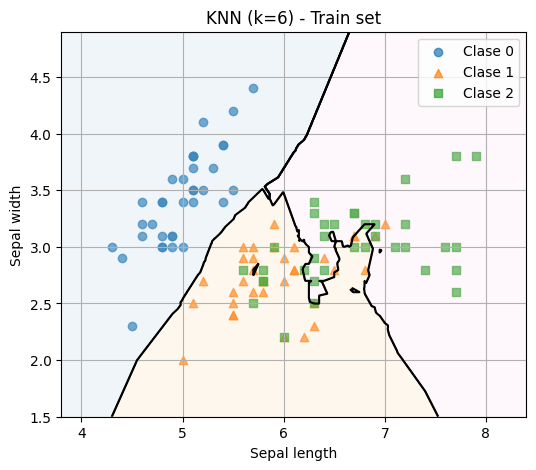

In [ ]:
import matplotlib.pyplot as plt

def plot_scatter_sepal(X, y, title="Scatter - Sepal"):
    markers = ['o', '^', 's']
    for clase in np.unique(y):
        plt.scatter(
            X[y == clase, 0],
            X[y == clase, 1],
            alpha=0.7,
            marker=markers[clase],
            label=f"Clase {clase}"
        )
    plt.title(title)
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.legend()
    plt.grid(True)

def plot_knn_boundaries(knn_model, X, y, title="KNN (k=6)"):
    # scatter
    plot_scatter_sepal(X, y, title)

    # Malla
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 2000),
        np.linspace(y_min, y_max, 2000)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Clases
    Z = knn_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Regiones con contourf
    plt.contourf(
        xx, yy, Z,
        alpha=0.2,
        levels=[-0.5, 0.5, 1.5, 2.5],
        cmap=plt.cm.Pastel1
    )
    plt.contour(xx, yy, Z, levels=[0.5,1.5], colors='k')

    plt.show()

# Instanciar KNN con K=6
knn_clf = KNN(n_neighbors=6)
# Entrenamiento
knn_clf.fit(X_train, y_train)

# Predicción en test
y_pred_knn = knn_clf.predict(X_test)

# Gráfico del set de entrenamiento
plt.figure(figsize=(6,5))
plot_knn_boundaries(knn_clf, X_train, y_train, "KNN (k=6) - Train set")


## Accuracy de testeo

El método KNN reporta una exactitud de 82.2\% (con K=6) usando solo las dimensiones de sépalo. Esto sugiere que comparado con LDA y QDA, KNN logra un rendimiento algo mayor en este plano, aunque persiste cierta confusión entre *versicolor* y *virginica*.

El resultado es razonablemente bueno y demuestra que KNN aprovecha mejor la distribución de muestras locales, a costa de un mayor costo computacional en predicción.

In [ ]:
# Evaluar accuracy
accuracy_knn = np.mean(y_pred_knn == y_test)
print(f"Accuracy (Test) con KNN (k=6): {accuracy_knn*100:.2f}%")


Accuracy (Test) con KNN (k=6): 82.22%


# Conclusiones

Como conclusión se puede observar que:
- **LDA** y **QDA** son métodos paramétricos que asumen distribuciones gaussianas para las clases, generando límites de decisión lineales y cuadráticos respectivamente. Son más rápidos en la predicción, pero hacen supuestos fuertes sobre los datos.
- **KNN** es un método no paramétrico que no hace suposiciones sobre la distribución de los datos y basa sus predicciones en la similitud con los datos de entrenamiento. Es flexible para límites de decisión complejos, pero puede ser lento en la predicción y sensible a la dimensionalidad de los datos.
